In [594]:
import numpy as np
import pandas as pd

import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
sys.path.append("../../..")


import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso 
from sklearn.decomposition import PCA #USE PCA FOR PCR REGRESSION
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import datetime
import math
from tslib.src import tsUtils
from tslib.src.synthcontrol.syntheticControl import RobustSyntheticControl
from tslib.tests import testdata

import statsmodels.api as sm
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [595]:
# Link for NFL Attendance Data: https://docs.google.com/spreadsheets/d/1DRMB5FLC3tdngeurDwps1CS8-6smEZvmq5R-ghjEv5k/edit#gid=0


#Import NFL Attendance Data using Pandas
attendance_df = pd.read_csv('NFL_Data.csv')

#Lots of NaN values, remove values without 'Team'
attendance_df = attendance_df.loc[~attendance_df['Team'].isnull()]

#Import NFL stadium County data, along with Neutral Counties
stadium_county_df = pd.read_csv('Stadium_County.csv',header=1) #Data is a little bit Messy 


#County Covid Rates Provided from NYTIMES Github Database, https://github.com/nytimes/covid-19-data/blob/master/us-counties-2020.csv
county_covid = pd.read_csv('County_Covid_Data.csv')


stadium_county_df['Team '].fillna(method = 'ffill', inplace= True)
stadium_county_df.rename(columns={'Team ': 'Team'}, inplace=True)
county_covid['date'] = pd.to_datetime(county_covid['date'])
county_covid = county_covid.loc[~(county_covid['county'] == 'Unknown')]
county_covid = county_covid.loc[~(county_covid['cases'].isnull())]
county_covid['county'] = county_covid['county'].apply(lambda x: x.lower() if isinstance(x, str) else x)



In [596]:
#We want to fill in state/county Data for cities that don't have stadium counties listed. Go through 1 by 1
no_fans_list = ['Buffalo', 'Chicago', 'Detroit', 'Green Bay', 'Las Vegas', 'LA Chargers','LA Rams', 'Minnesota', 'New England', 'New Orleans', 'NY Giants','NY Jets', 'San Francisco', 'Seattle', 'Washington']
stadium_county_df.loc[stadium_county_df['Team'] == 'Arizona', 'State'] = 'AZ'
stadium_county_df.loc[stadium_county_df['Team'] == 'Chicago', 'State'] = 'IL'

stadium_county_df.loc[stadium_county_df['Team'] == 'Detroit', 'State'] = 'MI'

stadium_county_df.loc[stadium_county_df['Team'] == 'Las Vegas', 'State'] = 'NV'

stadium_county_df.loc[stadium_county_df['Team'] == 'LA Chargers', 'State'] = 'CA'

stadium_county_df.loc[stadium_county_df['Team'] == 'LA Rams', 'State'] = 'CA'

stadium_county_df.loc[stadium_county_df['Team'] == 'Minnesota', 'State'] = 'MN'

stadium_county_df.loc[stadium_county_df['Team'] == 'New England', 'State'] = 'MA'

stadium_county_df.loc[stadium_county_df['Team'] == 'New Orleans', 'State'] = 'LA'

stadium_county_df.loc[stadium_county_df['Team'] == 'NY Giants', 'State'] = 'NJ'

stadium_county_df.loc[stadium_county_df['Team'] == 'NY Jets', 'State'] = 'NJ'

stadium_county_df.loc[stadium_county_df['Team'] == 'San Francisco', 'State'] = 'CA'

stadium_county_df.loc[stadium_county_df['Team'] == 'Seattle', 'State'] = 'WA'

stadium_county_df.loc[stadium_county_df['Team'] == 'Washington', 'State'] = 'District of Columbia'

stadium_county_df.loc[stadium_county_df['Team'] == 'Arizona', 'County(s)'] = 'Maricopa'
stadium_county_df.loc[stadium_county_df['Team'] == 'Chicago', 'County(s)'] = 'Cook'
stadium_county_df.loc[stadium_county_df['Team'] == 'Detroit', 'County(s)'] = 'Wayne'
stadium_county_df.loc[stadium_county_df['Team'] == 'Las Vegas', 'County(s)'] = 'Clark'
stadium_county_df.loc[stadium_county_df['Team'] == 'LA Chargers', 'County(s)'] = 'Los Angeles'
stadium_county_df.loc[stadium_county_df['Team'] == 'LA Rams', 'County(s)'] = 'Los Angeles'
stadium_county_df.loc[stadium_county_df['Team'] == 'Minnesota', 'County(s)'] = 'Ramsey'
stadium_county_df.loc[stadium_county_df['Team'] == 'New England', 'County(s)'] = 'Norfolk'
stadium_county_df.loc[stadium_county_df['Team'] == 'New Orleans', 'County(s)'] = 'Orleans'
stadium_county_df.loc[stadium_county_df['Team'] == 'NY Giants', 'County(s)'] = 'Bergen'
stadium_county_df.loc[stadium_county_df['Team'] == 'NY Jets', 'County(s)'] = 'Bergen'
stadium_county_df.loc[stadium_county_df['Team'] == 'San Francisco', 'County(s)'] = 'Santa Clara'
stadium_county_df.loc[stadium_county_df['Team'] == 'Seattle', 'County(s)'] = 'King'
stadium_county_df.loc[stadium_county_df['Team'] == 'Washington', 'County(s)'] = 'District of Columbia'

stadium_county_df['County(s)'] = stadium_county_df['County(s)'].apply(lambda x: x.lower() if isinstance(x, str) else x)

stadium_county_df['Counties'] = stadium_county_df['Counties'].apply(lambda x: x.lower() if isinstance(x, str) else x)



In [597]:
home_state_dict = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}


In [598]:

#We want to associate NFL teams to their respective Counties. Add Column that contains 'HOME COUNTIES', and columns that contains 'NEUTRAL COUNTIES'

#attendance_df['Team City'] = attendance_df.Team.str.split().str[:-1].str.join(sep=' ') #To connect with county information


#Change exceptions with 2 name cities



def find_stadium_counties(team_city_str):
    team_city_data = stadium_county_df.loc[stadium_county_df['Team'] == team_city_str]
    #team_city_data = team_city_data[team_city_data['County(s)'].notnull()]
    
    #Take away counties that don't belong in home state
    home_state = list(team_city_data['State'])[0]
    team_city_data = team_city_data[team_city_data['State.1'] == home_state]
    
    if team_city_str in no_fans_list:
        #If no fans, there actually is NO stadium county, since they are *not* affected by opening stadium. 
        return ""
    
    return list(set(team_city_data['County(s)']))

def find_donor_counties(team_city_str): #All counties within the state that is NOT in buffer counties.
    team_city_data = stadium_county_df.loc[stadium_county_df['Team'] == team_city_str]
    team_city_data = team_city_data[team_city_data['Counties'].notnull()]
    
    #Take away counties that don't belong in home state
    if(len(list(team_city_data['State'])) > 0): #If a home state exists... some not included in data set
        home_state = list(team_city_data['State'])[0]
    else: #Exceptions
        if team_city_str == 'Arizona':
            home_state = "AZ"
        elif team_city_str == 'Chicago':
            home_state = "IL"
        elif team_city_str == 'Detroit':
            home_state = "MI"
        elif team_city_str == 'Las Vegas':
            home_state = "NV"
        elif team_city_str == 'Chicago':
            home_state = "IL"
        elif team_city_str == 'LA Chargers':
            home_state = "CA"
        elif team_city_str == 'Kansas Chity':
            home_state = "MO"
        elif team_city_str == 'LA Rams':
            home_state = "CA"
        elif team_city_str == 'Minnesota':
            home_state = "MN"
        elif team_city_str == 'New England':
            home_state = "MA"
        elif team_city_str == 'New Orleans':
            home_state = "LA"
        elif team_city_str == 'NY Giants':
            home_state = "NJ"
        elif team_city_str == 'NY Jets':
            home_state = "NJ"
        elif team_city_str == 'San Francisco':
            home_state = "CA"
        elif team_city_str == 'Seattle':
            home_state = "WA"
        elif team_city_str == 'Washington':
            home_state = "MD"
        else:
            print(team_city_str)
            home_state = ''
            
    #Home State dictionary from 2 Letters to Full Name

    buffer_counties = list(set(stadium_county_df.loc[(stadium_county_df['State.1'] == home_state)]['Counties'])) #List of neutral counties IN HOME STATE
    
    stadium_counties = list(set(stadium_county_df.loc[(stadium_county_df['State'] == home_state)]['County(s)'])) #List of Stadium counties
    
    #Run through home_state_dict, as county_covid dataset uses full names for states rather than abbreviations
    home_state = home_state_dict[home_state]
    
    donor_counties = county_covid.loc[(county_covid['state'] == home_state)] #All county covid for home state

    donor_counties = donor_counties.loc[~donor_counties['county'].isin(buffer_counties) & (~donor_counties['county'].isin(stadium_counties))]

    donor_counties = donor_counties.loc[donor_counties['cases'] > 200]

    donor_counties = list(set(donor_counties['county']))
    
    #Sanity Check
    if team_city_str == "Washington":
        print(home_state)
        print(donor_counties)
        print(stadium_counties)
    


    return donor_counties

stadium_county_df['Stadium_Counties'] = stadium_county_df['Team'].apply(find_stadium_counties)
stadium_county_df['Donor_Counties'] = stadium_county_df['Team'].apply(find_donor_counties)
    
    
stadium_county_df['Stadium_Counties'] = stadium_county_df['Stadium_Counties'].apply(lambda x: [s.lower() if isinstance(s, str) else s for s in x])
stadium_county_df['Donor_Counties'] = stadium_county_df['Donor_Counties'].apply(lambda x: [s.lower() if isinstance(s, str) else s for s in x])


Maryland
["queen anne's", 'dorchester', 'somerset', 'washington', 'calvert', 'kent', 'caroline', 'talbot', 'worcester', 'cecil', 'allegany', 'garrett', "prince george's", "st. mary's", 'charles', 'wicomico']
['baltimore', 'baltimore city']


In [599]:
stadium_county_df

,Team,First date home stadium open to fans,County(s),State,% fans,Counties,State.1,% fans.1,Unnamed: 8,Stadium_Counties,Donor_Counties
0,Arizona,10/25/2020,maricopa,AZ,NaN,NaN,NaN,NaN,NaN,[],"[pinal, santa cruz, coconino, graham, gila, na..."
1,Atlanta,10/25/2020,fulton,GA,18.63,cobb,GA,8.24,"April 12, 2020: Our database changed to exclud...","[nan, fulton]","[mcintosh, polk, greene, ware, dougherty, toom..."
2,Atlanta,NaN,NaN,NaN,NaN,dekalb,GA,7.84,NaN,"[nan, fulton]","[mcintosh, polk, greene, ware, dougherty, toom..."
3,Atlanta,NaN,NaN,NaN,NaN,gwinnett,GA,7.05,NaN,"[nan, fulton]","[mcintosh, polk, greene, ware, dougherty, toom..."
4,Atlanta,NaN,NaN,NaN,NaN,hall,GA,2.49,NaN,"[nan, fulton]","[mcintosh, polk, greene, ware, dougherty, toom..."
...,...,...,...,...,...,...,...,...,...,...,...
180,Tennessee,NaN,NaN,NaN,NaN,warren,KY,1.23,NaN,"[nan, davidson, williamson]","[polk, greene, chester, perry, lawrence, white..."
181,Tennessee,NaN,NaN,NaN,NaN,knox,TN,1.17,NaN,"[nan, davidson, williamson]","[polk, greene, chester, perry, lawrence, white..."
182,Tennessee,NaN,NaN,NaN,NaN,cook,IL,1.01,NaN,"[nan, davidson, williamson]","[polk, greene, chester, perry, lawrence, white..."
183,Tennessee,NaN,NaN,NaN,NaN,cheatham,TN,1.01,NaN,"[nan, davidson, williamson]","[polk, greene, chester, perry, lawrence, white..."


In [619]:
#Make earlier process into a function to generalize to other Stadiums

Total_prediction_data_fans = []
Total_prediction_data_no_fans = []

def create_synthetic_graph(team_name_str, stadium_county_str, state_str, intervention_date, show_plot, week):
    print(team_name_str)
    
    stadium_county_str = [x for x in stadium_county_str if x != ""]
    state_str = [x for x in state_str if x != ""]
    intervention_date = [x for x in intervention_date if x != ""]
    
    #Convert to lower case to avoid case insensitivity later
    stadium_county_str = [s.lower() for s in stadium_county_str]
    #To find intervention_date, we want first entry that has numbers, since some in data is text only.
    for s in intervention_date:
        if any(c.isdigit() for c in s):
            intervention_date = s

    intervention_date = pd.to_datetime(intervention_date)
    

    #Convert State Acronym to full state name
    for state in range(len(state_str)):
        if state_str[state] in home_state_dict:
            state_str[state] = home_state_dict[state_str[state]]
            
    #Find Synthetic Counties
    synthetic_counties = list(stadium_county_df.loc[stadium_county_df['Team'] == team_name_str]['Donor_Counties'])[0].copy()
    synthetic_counties = [s.lower() for s in synthetic_counties]
    n_donors = len(synthetic_counties)
    
    print(stadium_county_str)
#     print(sorted(synthetic_counties))
    
    #Find Dataframe of X and Y data
    #Special case where 
    if team_name_str == 'Washington':
        stadium_county_data = county_covid.loc[(county_covid['county'].isin(stadium_county_str)) | ((county_covid['county'].isin(synthetic_counties)) & (county_covid['state'] == 'Maryland'))]
    else:
        stadium_county_data = county_covid.loc[(county_covid['county'].isin(stadium_county_str) | (county_covid['county'].isin(synthetic_counties))) & (county_covid['state'].isin(state_str))]
    
    stadium_county_data = stadium_county_data.fillna(method='bfill')
    stadium_county_data['date'] = pd.to_datetime(stadium_county_data['date'], infer_datetime_format=True)
    
    earliest_date = list(stadium_county_data.loc[stadium_county_data['county'].isin(stadium_county_str)]['date'])[0]
    
    #Start training from the earliest date of when our stadium county data becomes available.
    stadium_county_data = stadium_county_data.loc[stadium_county_data['date'] >= earliest_date]
    
    #CONVERT ALL OF THIS INTO A PIVOT TABLE FIRST
    
    ########
    
    
    #Total Pivot is pivot table cases for entire dataset, training pivot is the same but for < intervention date
    total_pivot = stadium_county_data.pivot_table(columns='county', values='cases', index= 'date').reset_index()
    total_pivot = total_pivot.loc[total_pivot['date'] >= earliest_date]
    
    #Sum up stadium counties for our prediction. 
    total_pivot['Stadium_County'] = total_pivot.apply(lambda row: row[stadium_county_str].sum(), axis=1)
    #total_pivot['Stadium_County'] = total_pivot.loc[:, total_pivot.columns == (stadium_county_str[0])]
    
    total_pivot.drop(stadium_county_str, axis=1, inplace=True)
    
    total_pivot.fillna(0, inplace=True)
    
    training_pivot = total_pivot.loc[total_pivot['date'] < intervention_date]
    
    training_dates = training_pivot['date']
    
    total_dates = total_pivot['date']
    
    training_pivot = training_pivot.drop(['date'], axis=1)
    
    total_pivot = total_pivot.drop(['date'], axis=1)
    
    X_train = training_pivot.loc[:, ~training_pivot.columns.isin(['Stadium_County'])]
    
    Y_train = training_pivot['Stadium_County']
    
    num_pre_dates = X_train.shape[0]
    
    
    #Keep total X and Y data for future plots
    total_X = total_pivot.loc[:, ~total_pivot.columns.isin(['Stadium_County'])]
    total_Y = total_pivot['Stadium_County']
    
    assert total_X.shape[0] == total_Y.shape[0]
    
    
    ###########
    
    U, S, V = np.linalg.svd(X_train, full_matrices=False)

    total_columns = X_train.columns
    stadium_key = 'Stadium_County'
    donor_key = total_columns
    
    aggregate_errors = []
    r_squareds = []
    
    for svalue in range(1,len(S)+1):
        

        singvals = svalue
        rscModel = RobustSyntheticControl(stadium_key, singvals, len(training_pivot), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=donor_key)
        rscModel.fit(training_pivot)
        
        denoisedDF = rscModel.model.denoisedDF()

        predictions = []
        predictions = np.dot(X_train, rscModel.model.weights) #Prediction fits pre-intervention
        #predictions = predictions.astype(int)
        
        assert predictions.shape[0] == num_pre_dates
        
        aggregate_y = Y_train # Actual Y cases 

        assert len(aggregate_y) == len(predictions)
        
        
        aggregate_error = np.linalg.norm(aggregate_y - predictions) / np.linalg.norm(aggregate_y)

        aggregate_errors.append(aggregate_error)
    

        if (aggregate_error < 0.01):
            
#             print("Our final Kept singular values")
            print(svalue)
            break
            
            
        if svalue == (len(S)):
            print("Uses all singular values initially")
            
            if min(aggregate_errors) < 0.015:
                svalue = aggregate_errors.index(list(filter(lambda k: k < 0.015, aggregate_errors))[0]) + 1
                
            elif min(aggregate_errors) < 0.02:
                svalue = aggregate_errors.index(list(filter(lambda k: k < 0.02, aggregate_errors))[0]) + 1
            else:
                svalue = len(S)
            print("Our final Kept singular value")
            print(svalue)
            break
        
    total_columns = total_X.columns
    stadium_key = 'Stadium_County'
    donor_key = total_columns
    
#     if team_name_str == 'San Francisco':
#         svalue = 9
#     if team_name_str == 'Seattle':
#         svalue = 12
    


    rscModel = RobustSyntheticControl(stadium_key, svalue, len(training_pivot), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=donor_key)
    rscModel.fit(training_pivot)
    denoisedDF = rscModel.model.denoisedDF()
    
    predictions = []
    predictions = np.dot(total_X, rscModel.model.weights)

    #Following adds prediction data to construct historgram results T+days after intervention date
    if team_name_str in no_fans_list:
        Total_prediction_data_no_fans.append((-predictions[num_pre_dates:num_pre_dates + 21] +
                                     list(total_Y)[num_pre_dates:num_pre_dates + 21])/
                                             predictions[num_pre_dates:num_pre_dates + 21])
    else:
        Total_prediction_data_fans.append((-predictions[num_pre_dates:num_pre_dates + 21] +
                                     list(total_Y)[num_pre_dates:num_pre_dates + 21])/
                                          predictions[num_pre_dates:num_pre_dates + 21])
    
    assert predictions.shape[0] == total_Y.shape[0]
    
    if show_plot == True:

        #Plot Hamilton_synthetic along with actual Hamilton data past 10/4 results. 
        fig, ax = plt.subplots()


        plt.plot(total_dates, total_Y, label = stadium_county_str)
        plt.plot(total_dates, predictions, label='Synthetic RBSC')
        
        plt.xticks(rotation=45)
        plt.title(team_name_str + " " + stadium_county_str[0] + " County Covid Cases ")

        plt.tick_params(axis='x', which='major')
        plt.axvline(x=intervention_date, ymin = 0, ymax = 1, color='grey')
        fig.autofmt_xdate()

        ax.legend()
        ax.xaxis_date()
        plt.show()
    else: #Below is for Synthetic Lines, which plots all six weeks onto the same plot. 
        true_intervention = intervention_date + datetime.timedelta(weeks=week)
        
        if week == 0:
            plt.plot(total_dates, predictions, label='Synthetic Week Before', color = 'blue')
        else:
            plt.plot(total_dates, predictions, label='Synthetic Week Before', color = 'grey')

        plt.xticks(rotation=45)
        plt.title(team_name_str + " " + stadium_county_str[0] + " County Covid Cases ")
        

        plt.tick_params(axis='x', which='major')
        plt.axvline(x=true_intervention, ymin = 0, ymax = 1, color='grey')
        #plt.axvline(x=intervention_date, ymin = 0, ymax = 1, color='grey')

    return 


Kansas City
['johnson', 'jackson']
['allen', 'anderson', 'atchison', 'barber', 'barton', 'bourbon', 'brown', 'butler', 'chase', 'cherokee', 'cheyenne', 'clay', 'cloud', 'coffey', 'cowley', 'crawford', 'decatur', 'dickinson', 'doniphan', 'douglas', 'edwards', 'ellis', 'ellsworth', 'finney', 'ford', 'franklin', 'geary', 'gove', 'graham', 'grant', 'gray', 'greenwood', 'harper', 'harvey', 'haskell', 'jackson', 'jefferson', 'kearny', 'kingman', 'labette', 'leavenworth', 'lincoln', 'linn', 'logan', 'lyon', 'marion', 'marshall', 'mcpherson', 'meade', 'miami', 'mitchell', 'montgomery', 'morris', 'morton', 'nemaha', 'neosho', 'ness', 'norton', 'osage', 'ottawa', 'pawnee', 'phillips', 'pottawatomie', 'pratt', 'rawlins', 'reno', 'republic', 'rice', 'riley', 'rooks', 'rush', 'russell', 'saline', 'scott', 'seward', 'sheridan', 'sherman', 'smith', 'stafford', 'stevens', 'sumner', 'thomas', 'trego', 'wabaunsee', 'washington', 'wilson']
10


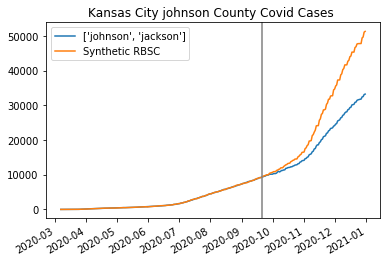

In [620]:
create_synthetic_graph("Kansas City",["Johnson", "Jackson"], ["KS", "MO"], ["09/21/2020"], True, 0)

Arizona
['maricopa']
['apache', 'cochise', 'coconino', 'gila', 'graham', 'greenlee', 'la paz', 'mohave', 'navajo', 'pima', 'pinal', 'santa cruz', 'yavapai', 'yuma']
7


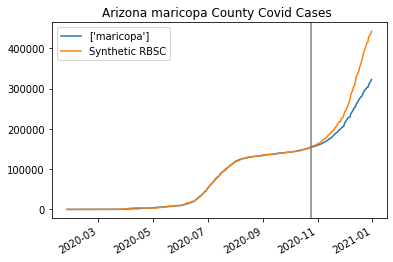

Atlanta
['fulton']
['appling', 'atkinson', 'bacon', 'baldwin', 'banks', 'barrow', 'bartow', 'ben hill', 'berrien', 'bibb', 'bleckley', 'brantley', 'brooks', 'bryan', 'bulloch', 'burke', 'butts', 'calhoun', 'candler', 'carroll', 'catoosa', 'charlton', 'chatham', 'chattahoochee', 'chattooga', 'clarke', 'clinch', 'coffee', 'colquitt', 'columbia', 'cook', 'coweta', 'crawford', 'crisp', 'dade', 'dawson', 'decatur', 'dodge', 'dooly', 'dougherty', 'early', 'echols', 'effingham', 'elbert', 'emanuel', 'evans', 'fannin', 'floyd', 'franklin', 'gilmer', 'glynn', 'gordon', 'grady', 'greene', 'habersham', 'hancock', 'haralson', 'harris', 'hart', 'heard', 'houston', 'irwin', 'jackson', 'jasper', 'jeff davis', 'jefferson', 'jenkins', 'johnson', 'jones', 'lamar', 'lanier', 'laurens', 'lee', 'liberty', 'lincoln', 'long', 'lowndes', 'lumpkin', 'macon', 'madison', 'marion', 'mcduffie', 'mcintosh', 'meriwether', 'miller', 'mitchell', 'monroe', 'montgomery', 'morgan', 'murray', 'muscogee', 'newton', 'oconee

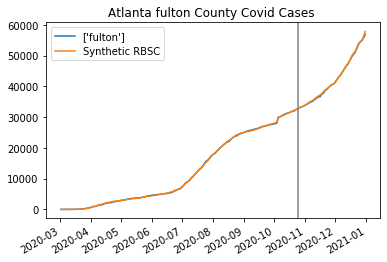

Baltimore
['baltimore', 'baltimore city']
['allegany', 'calvert', 'caroline', 'cecil', 'charles', 'dorchester', 'garrett', 'kent', "prince george's", "queen anne's", 'somerset', "st. mary's", 'talbot', 'washington', 'wicomico', 'worcester']
5


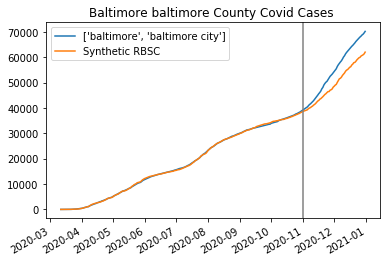

Buffalo
['erie']
['albany', 'allegany', 'broome', 'cattaraugus', 'cayuga', 'chemung', 'chenango', 'clinton', 'columbia', 'cortland', 'delaware', 'dutchess', 'essex', 'franklin', 'fulton', 'greene', 'herkimer', 'jefferson', 'lewis', 'livingston', 'madison', 'montgomery', 'nassau', 'new york city', 'oneida', 'onondaga', 'orange', 'orleans', 'oswego', 'otsego', 'putnam', 'rensselaer', 'rockland', 'saratoga', 'schenectady', 'schoharie', 'schuyler', 'seneca', 'st. lawrence', 'steuben', 'suffolk', 'sullivan', 'tioga', 'tompkins', 'ulster', 'warren', 'washington', 'wayne', 'westchester', 'wyoming', 'yates']
10


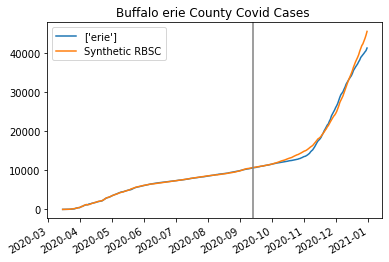

Carolina
['mecklenburg']
['alamance', 'alexander', 'alleghany', 'anson', 'ashe', 'avery', 'beaufort', 'bertie', 'bladen', 'brunswick', 'buncombe', 'burke', 'caldwell', 'camden', 'carteret', 'caswell', 'chatham', 'cherokee', 'chowan', 'clay', 'cleveland', 'columbus', 'craven', 'cumberland', 'currituck', 'dare', 'davidson', 'davie', 'duplin', 'durham', 'edgecombe', 'franklin', 'gates', 'graham', 'granville', 'greene', 'halifax', 'harnett', 'haywood', 'henderson', 'hertford', 'hoke', 'hyde', 'jackson', 'johnston', 'jones', 'lee', 'lenoir', 'lincoln', 'macon', 'madison', 'martin', 'mcdowell', 'mitchell', 'montgomery', 'moore', 'nash', 'new hanover', 'northampton', 'onslow', 'orange', 'pamlico', 'pasquotank', 'pender', 'perquimans', 'person', 'pitt', 'polk', 'randolph', 'richmond', 'robeson', 'rockingham', 'rowan', 'rutherford', 'sampson', 'scotland', 'stanly', 'stokes', 'surry', 'swain', 'transylvania', 'vance', 'warren', 'washington', 'watauga', 'wayne', 'wilkes', 'wilson', 'yadkin', 'yan

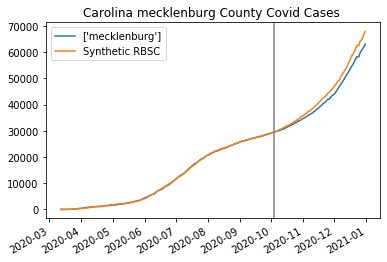

Chicago
['cook']
['adams', 'alexander', 'bond', 'boone', 'brown', 'bureau', 'calhoun', 'carroll', 'cass', 'champaign', 'christian', 'clark', 'clay', 'clinton', 'coles', 'crawford', 'cumberland', 'de witt', 'dekalb', 'douglas', 'dupage', 'edgar', 'edwards', 'effingham', 'fayette', 'ford', 'franklin', 'fulton', 'gallatin', 'greene', 'grundy', 'hamilton', 'hancock', 'hardin', 'henderson', 'henry', 'iroquois', 'jackson', 'jasper', 'jefferson', 'jersey', 'jo daviess', 'johnson', 'kane', 'kankakee', 'kendall', 'knox', 'lake', 'lasalle', 'lawrence', 'lee', 'livingston', 'logan', 'macon', 'macoupin', 'madison', 'marion', 'marshall', 'mason', 'massac', 'mcdonough', 'mchenry', 'mclean', 'menard', 'mercer', 'monroe', 'montgomery', 'morgan', 'moultrie', 'ogle', 'peoria', 'perry', 'piatt', 'pike', 'pulaski', 'putnam', 'randolph', 'richland', 'rock island', 'saline', 'sangamon', 'schuyler', 'scott', 'shelby', 'st. clair', 'stark', 'stephenson', 'tazewell', 'union', 'vermilion', 'wabash', 'warren', '

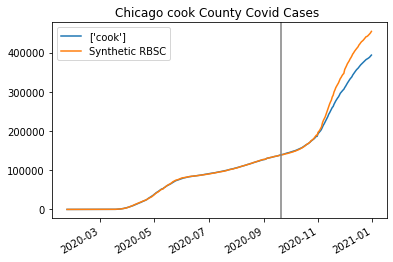

Cincinnati
['hamilton']
['adams', 'allen', 'ashland', 'ashtabula', 'athens', 'auglaize', 'belmont', 'brown', 'carroll', 'champaign', 'clark', 'clinton', 'columbiana', 'coshocton', 'crawford', 'darke', 'defiance', 'delaware', 'erie', 'fairfield', 'fayette', 'fulton', 'gallia', 'guernsey', 'hancock', 'hardin', 'harrison', 'henry', 'highland', 'hocking', 'holmes', 'huron', 'jackson', 'jefferson', 'knox', 'lawrence', 'licking', 'logan', 'lucas', 'madison', 'marion', 'meigs', 'mercer', 'miami', 'monroe', 'morgan', 'morrow', 'muskingum', 'noble', 'ottawa', 'paulding', 'perry', 'pickaway', 'pike', 'preble', 'putnam', 'richland', 'ross', 'sandusky', 'scioto', 'seneca', 'shelby', 'tuscarawas', 'union', 'van wert', 'vinton', 'washington', 'wayne', 'williams', 'wood', 'wyandot']
12


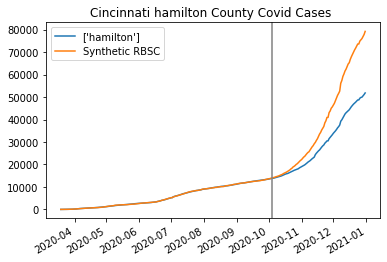

Cleveland
['cuyahoga']
['adams', 'allen', 'ashland', 'ashtabula', 'athens', 'auglaize', 'belmont', 'brown', 'carroll', 'champaign', 'clark', 'clinton', 'columbiana', 'coshocton', 'crawford', 'darke', 'defiance', 'delaware', 'erie', 'fairfield', 'fayette', 'fulton', 'gallia', 'guernsey', 'hancock', 'hardin', 'harrison', 'henry', 'highland', 'hocking', 'holmes', 'huron', 'jackson', 'jefferson', 'knox', 'lawrence', 'licking', 'logan', 'lucas', 'madison', 'marion', 'meigs', 'mercer', 'miami', 'monroe', 'morgan', 'morrow', 'muskingum', 'noble', 'ottawa', 'paulding', 'perry', 'pickaway', 'pike', 'preble', 'putnam', 'richland', 'ross', 'sandusky', 'scioto', 'seneca', 'shelby', 'tuscarawas', 'union', 'van wert', 'vinton', 'washington', 'wayne', 'williams', 'wood', 'wyandot']
15


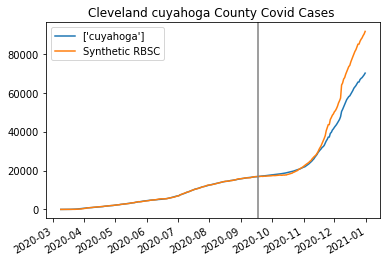

Dallas
['dallas', 'tarrant']
['anderson', 'andrews', 'angelina', 'aransas', 'archer', 'atascosa', 'austin', 'bailey', 'bandera', 'bastrop', 'baylor', 'bee', 'bell', 'blanco', 'bosque', 'bowie', 'brazos', 'brewster', 'brooks', 'brown', 'burleson', 'burnet', 'caldwell', 'calhoun', 'callahan', 'cameron', 'camp', 'carson', 'cass', 'castro', 'chambers', 'cherokee', 'childress', 'clay', 'cochran', 'coke', 'coleman', 'collingsworth', 'colorado', 'comal', 'comanche', 'concho', 'cooke', 'coryell', 'crane', 'crockett', 'crosby', 'culberson', 'dallam', 'dawson', 'deaf smith', 'dewitt', 'dimmit', 'donley', 'duval', 'eastland', 'ellis', 'erath', 'falls', 'fannin', 'fayette', 'fisher', 'floyd', 'franklin', 'freestone', 'frio', 'gaines', 'garza', 'gillespie', 'goliad', 'gonzales', 'gray', 'grayson', 'gregg', 'grimes', 'guadalupe', 'hale', 'hall', 'hamilton', 'hansford', 'hardeman', 'hardin', 'harrison', 'hartley', 'haskell', 'hays', 'hemphill', 'henderson', 'hill', 'hockley', 'hood', 'hopkins', 'hous

KeyboardInterrupt: 

In [613]:
#Compute graphs for all combinations 

no_fans_list = ['Buffalo', 'Chicago', 'Detroit', 'Green Bay', 'Las Vegas', 'LA Chargers','LA Rams', 'Minnesota', 'New England', 'New Orleans', 'NY Giants','NY Jets', 'San Francisco', 'Seattle', 'Washington']
Total_prediction_data_fans = []
Total_prediction_data_no_fans = []
dropped_stadium_df = stadium_county_df.copy()
dropped_stadium_df = dropped_stadium_df[['Team', 'First date home stadium open to fans','County(s)', 'State']]
dropped_stadium_df = dropped_stadium_df.fillna("")
grouped_df = dropped_stadium_df.groupby('Team').agg(list)
grouped_df.reset_index(inplace=True)


#We want to manually fill in Dates for stadiums not open to fans, easier this way. 
grouped_df.loc[grouped_df['Team'] == 'Chicago', 'First date home stadium open to fans'] = [['9/20/2020']]
grouped_df.loc[grouped_df['Team'] == 'Detroit', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Las Vegas', 'First date home stadium open to fans'] = [['9/21/2020']]
grouped_df.loc[grouped_df['Team'] == 'LA Chargers', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'LA Rams', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Minnesota', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'New England', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'New Orleans', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'NY Giants', 'First date home stadium open to fans'] = [['9/14/2020']]
grouped_df.loc[grouped_df['Team'] == 'NY Jets', 'First date home stadium open to fans'] = [['9/14/2020']]
grouped_df.loc[grouped_df['Team'] == 'San Francisco', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Seattle', 'First date home stadium open to fans'] = [['9/20/2020']]
grouped_df.loc[grouped_df['Team'] == 'Tennessee', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Washington', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Pittsburgh', 'First date home stadium open to fans'] = [['10/11/2020']]
grouped_df.loc[grouped_df['Team'] == 'Kansas City', 'First date home stadium open to fans'] = [['9/10/2020']] #Error in data set



#dropped_stadium_df = dropped_stadium_df.drop_duplicates(subset='Team') #Only need 1 for each team
zipped_input = zip(grouped_df['Team'], grouped_df['County(s)'], grouped_df['State'], grouped_df['First date home stadium open to fans'])

# for i, (team, county, state, date) in enumerate(zipped_input):
#     if (team != 'Washington'):
#         create_synthetic_graph(team, county, state, date)
    
for i, (team, county, state, date) in enumerate(zipped_input):

    if (team != 'Washington'):
        create_synthetic_graph(team, county, state, date, True, 0)
    else:
        create_synthetic_graph('Kansas City',["Johnson", "Jackson"] ,["MO"], ['9/10/2020'], True, 0)


In [621]:
#Make earlier function to be able to graph weeks 1-6 before the intervention. 
no_fans_list = ['Buffalo', 'Chicago', 'Detroit', 'Green Bay', 'Las Vegas', 'LA Chargers','LA Rams', 'Minnesota', 'New England', 'New Orleans', 'NY Giants','NY Jets', 'San Francisco', 'Seattle', 'Washington']

def create_synthetic_lines(team_name_str, stadium_county_str, state_str, intervention_date):
    intervention_date = [x for x in intervention_date if x != ""]
    
    for s in intervention_date:
        if any(c.isdigit() for c in s):
            intervention_date = s
            
    intervention_date = pd.to_datetime(intervention_date)
    intervention_array = [intervention_date - datetime.timedelta(weeks=i) for i in range(0, 7)]
    print(team_name_str)
    count = 0
    for intervention in intervention_array: 
        
        intervention = intervention.strftime('%m/%d/%Y')
        l = []
        l.append(intervention)
        l.append("")
        
        create_synthetic_graph(team_name_str, stadium_county_str, state_str, l, False, count)
        
        count += 1
    plt.show()
    
    return 


Arizona
Arizona
['maricopa']
['apache', 'cochise', 'coconino', 'gila', 'graham', 'greenlee', 'la paz', 'mohave', 'navajo', 'pima', 'pinal', 'santa cruz', 'yavapai', 'yuma']
7
Arizona
['maricopa']
['apache', 'cochise', 'coconino', 'gila', 'graham', 'greenlee', 'la paz', 'mohave', 'navajo', 'pima', 'pinal', 'santa cruz', 'yavapai', 'yuma']
7
Arizona
['maricopa']
['apache', 'cochise', 'coconino', 'gila', 'graham', 'greenlee', 'la paz', 'mohave', 'navajo', 'pima', 'pinal', 'santa cruz', 'yavapai', 'yuma']
Uses all singular values initially
Our final Kept singular value
6
Arizona
['maricopa']
['apache', 'cochise', 'coconino', 'gila', 'graham', 'greenlee', 'la paz', 'mohave', 'navajo', 'pima', 'pinal', 'santa cruz', 'yavapai', 'yuma']
Uses all singular values initially
Our final Kept singular value
6
Arizona
['maricopa']
['apache', 'cochise', 'coconino', 'gila', 'graham', 'greenlee', 'la paz', 'mohave', 'navajo', 'pima', 'pinal', 'santa cruz', 'yavapai', 'yuma']
Uses all singular values init

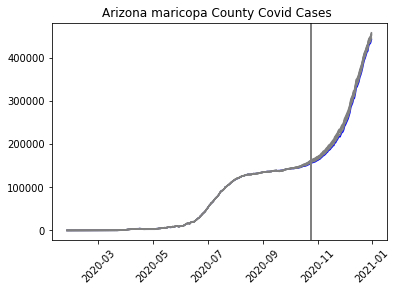

Atlanta
Atlanta
['fulton']
['appling', 'atkinson', 'bacon', 'baldwin', 'banks', 'barrow', 'bartow', 'ben hill', 'berrien', 'bibb', 'bleckley', 'brantley', 'brooks', 'bryan', 'bulloch', 'burke', 'butts', 'calhoun', 'candler', 'carroll', 'catoosa', 'charlton', 'chatham', 'chattahoochee', 'chattooga', 'clarke', 'clinch', 'coffee', 'colquitt', 'columbia', 'cook', 'coweta', 'crawford', 'crisp', 'dade', 'dawson', 'decatur', 'dodge', 'dooly', 'dougherty', 'early', 'echols', 'effingham', 'elbert', 'emanuel', 'evans', 'fannin', 'floyd', 'franklin', 'gilmer', 'glynn', 'gordon', 'grady', 'greene', 'habersham', 'hancock', 'haralson', 'harris', 'hart', 'heard', 'houston', 'irwin', 'jackson', 'jasper', 'jeff davis', 'jefferson', 'jenkins', 'johnson', 'jones', 'lamar', 'lanier', 'laurens', 'lee', 'liberty', 'lincoln', 'long', 'lowndes', 'lumpkin', 'macon', 'madison', 'marion', 'mcduffie', 'mcintosh', 'meriwether', 'miller', 'mitchell', 'monroe', 'montgomery', 'morgan', 'murray', 'muscogee', 'newton',

4
Atlanta
['fulton']
['appling', 'atkinson', 'bacon', 'baldwin', 'banks', 'barrow', 'bartow', 'ben hill', 'berrien', 'bibb', 'bleckley', 'brantley', 'brooks', 'bryan', 'bulloch', 'burke', 'butts', 'calhoun', 'candler', 'carroll', 'catoosa', 'charlton', 'chatham', 'chattahoochee', 'chattooga', 'clarke', 'clinch', 'coffee', 'colquitt', 'columbia', 'cook', 'coweta', 'crawford', 'crisp', 'dade', 'dawson', 'decatur', 'dodge', 'dooly', 'dougherty', 'early', 'echols', 'effingham', 'elbert', 'emanuel', 'evans', 'fannin', 'floyd', 'franklin', 'gilmer', 'glynn', 'gordon', 'grady', 'greene', 'habersham', 'hancock', 'haralson', 'harris', 'hart', 'heard', 'houston', 'irwin', 'jackson', 'jasper', 'jeff davis', 'jefferson', 'jenkins', 'johnson', 'jones', 'lamar', 'lanier', 'laurens', 'lee', 'liberty', 'lincoln', 'long', 'lowndes', 'lumpkin', 'macon', 'madison', 'marion', 'mcduffie', 'mcintosh', 'meriwether', 'miller', 'mitchell', 'monroe', 'montgomery', 'morgan', 'murray', 'muscogee', 'newton', 'ocon

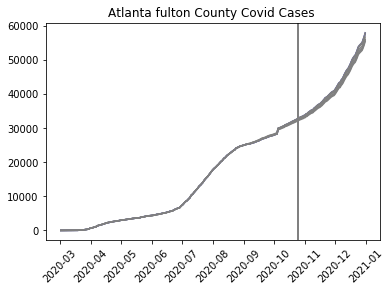

Baltimore
Baltimore
['baltimore', 'baltimore city']
['allegany', 'calvert', 'caroline', 'cecil', 'charles', 'dorchester', 'garrett', 'kent', "prince george's", "queen anne's", 'somerset', "st. mary's", 'talbot', 'washington', 'wicomico', 'worcester']
5
Baltimore
['baltimore', 'baltimore city']
['allegany', 'calvert', 'caroline', 'cecil', 'charles', 'dorchester', 'garrett', 'kent', "prince george's", "queen anne's", 'somerset', "st. mary's", 'talbot', 'washington', 'wicomico', 'worcester']
5
Baltimore
['baltimore', 'baltimore city']
['allegany', 'calvert', 'caroline', 'cecil', 'charles', 'dorchester', 'garrett', 'kent', "prince george's", "queen anne's", 'somerset', "st. mary's", 'talbot', 'washington', 'wicomico', 'worcester']
5
Baltimore
['baltimore', 'baltimore city']
['allegany', 'calvert', 'caroline', 'cecil', 'charles', 'dorchester', 'garrett', 'kent', "prince george's", "queen anne's", 'somerset', "st. mary's", 'talbot', 'washington', 'wicomico', 'worcester']
5
Baltimore
['baltim

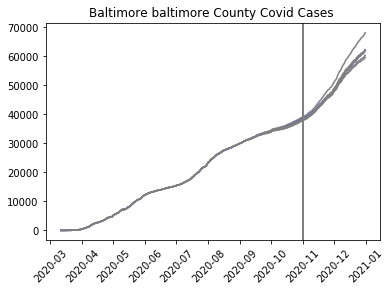

Buffalo
Buffalo
['erie']
['albany', 'allegany', 'broome', 'cattaraugus', 'cayuga', 'chemung', 'chenango', 'clinton', 'columbia', 'cortland', 'delaware', 'dutchess', 'essex', 'franklin', 'fulton', 'greene', 'herkimer', 'jefferson', 'lewis', 'livingston', 'madison', 'montgomery', 'nassau', 'new york city', 'oneida', 'onondaga', 'orange', 'orleans', 'oswego', 'otsego', 'putnam', 'rensselaer', 'rockland', 'saratoga', 'schenectady', 'schoharie', 'schuyler', 'seneca', 'st. lawrence', 'steuben', 'suffolk', 'sullivan', 'tioga', 'tompkins', 'ulster', 'warren', 'washington', 'wayne', 'westchester', 'wyoming', 'yates']
10
Buffalo
['erie']
['albany', 'allegany', 'broome', 'cattaraugus', 'cayuga', 'chemung', 'chenango', 'clinton', 'columbia', 'cortland', 'delaware', 'dutchess', 'essex', 'franklin', 'fulton', 'greene', 'herkimer', 'jefferson', 'lewis', 'livingston', 'madison', 'montgomery', 'nassau', 'new york city', 'oneida', 'onondaga', 'orange', 'orleans', 'oswego', 'otsego', 'putnam', 'rensselae

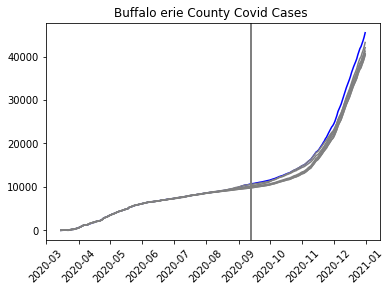

Carolina
Carolina
['mecklenburg']
['alamance', 'alexander', 'alleghany', 'anson', 'ashe', 'avery', 'beaufort', 'bertie', 'bladen', 'brunswick', 'buncombe', 'burke', 'caldwell', 'camden', 'carteret', 'caswell', 'chatham', 'cherokee', 'chowan', 'clay', 'cleveland', 'columbus', 'craven', 'cumberland', 'currituck', 'dare', 'davidson', 'davie', 'duplin', 'durham', 'edgecombe', 'franklin', 'gates', 'graham', 'granville', 'greene', 'halifax', 'harnett', 'haywood', 'henderson', 'hertford', 'hoke', 'hyde', 'jackson', 'johnston', 'jones', 'lee', 'lenoir', 'lincoln', 'macon', 'madison', 'martin', 'mcdowell', 'mitchell', 'montgomery', 'moore', 'nash', 'new hanover', 'northampton', 'onslow', 'orange', 'pamlico', 'pasquotank', 'pender', 'perquimans', 'person', 'pitt', 'polk', 'randolph', 'richmond', 'robeson', 'rockingham', 'rowan', 'rutherford', 'sampson', 'scotland', 'stanly', 'stokes', 'surry', 'swain', 'transylvania', 'vance', 'warren', 'washington', 'watauga', 'wayne', 'wilkes', 'wilson', 'yadk

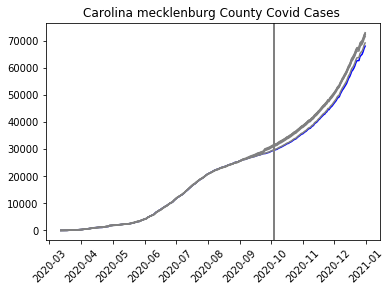

Chicago
Chicago
['cook']
['adams', 'alexander', 'bond', 'boone', 'brown', 'bureau', 'calhoun', 'carroll', 'cass', 'champaign', 'christian', 'clark', 'clay', 'clinton', 'coles', 'crawford', 'cumberland', 'de witt', 'dekalb', 'douglas', 'dupage', 'edgar', 'edwards', 'effingham', 'fayette', 'ford', 'franklin', 'fulton', 'gallatin', 'greene', 'grundy', 'hamilton', 'hancock', 'hardin', 'henderson', 'henry', 'iroquois', 'jackson', 'jasper', 'jefferson', 'jersey', 'jo daviess', 'johnson', 'kane', 'kankakee', 'kendall', 'knox', 'lake', 'lasalle', 'lawrence', 'lee', 'livingston', 'logan', 'macon', 'macoupin', 'madison', 'marion', 'marshall', 'mason', 'massac', 'mcdonough', 'mchenry', 'mclean', 'menard', 'mercer', 'monroe', 'montgomery', 'morgan', 'moultrie', 'ogle', 'peoria', 'perry', 'piatt', 'pike', 'pulaski', 'putnam', 'randolph', 'richland', 'rock island', 'saline', 'sangamon', 'schuyler', 'scott', 'shelby', 'st. clair', 'stark', 'stephenson', 'tazewell', 'union', 'vermilion', 'wabash', 'wa

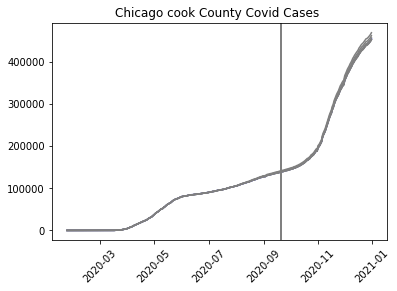

Cincinnati
Cincinnati
['hamilton']
['adams', 'allen', 'ashland', 'ashtabula', 'athens', 'auglaize', 'belmont', 'brown', 'carroll', 'champaign', 'clark', 'clinton', 'columbiana', 'coshocton', 'crawford', 'darke', 'defiance', 'delaware', 'erie', 'fairfield', 'fayette', 'fulton', 'gallia', 'guernsey', 'hancock', 'hardin', 'harrison', 'henry', 'highland', 'hocking', 'holmes', 'huron', 'jackson', 'jefferson', 'knox', 'lawrence', 'licking', 'logan', 'lucas', 'madison', 'marion', 'meigs', 'mercer', 'miami', 'monroe', 'morgan', 'morrow', 'muskingum', 'noble', 'ottawa', 'paulding', 'perry', 'pickaway', 'pike', 'preble', 'putnam', 'richland', 'ross', 'sandusky', 'scioto', 'seneca', 'shelby', 'tuscarawas', 'union', 'van wert', 'vinton', 'washington', 'wayne', 'williams', 'wood', 'wyandot']
12
Cincinnati
['hamilton']
['adams', 'allen', 'ashland', 'ashtabula', 'athens', 'auglaize', 'belmont', 'brown', 'carroll', 'champaign', 'clark', 'clinton', 'columbiana', 'coshocton', 'crawford', 'darke', 'defia

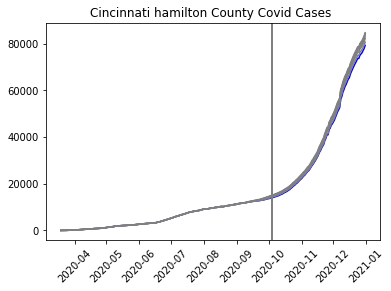

Cleveland
Cleveland
['cuyahoga']
['adams', 'allen', 'ashland', 'ashtabula', 'athens', 'auglaize', 'belmont', 'brown', 'carroll', 'champaign', 'clark', 'clinton', 'columbiana', 'coshocton', 'crawford', 'darke', 'defiance', 'delaware', 'erie', 'fairfield', 'fayette', 'fulton', 'gallia', 'guernsey', 'hancock', 'hardin', 'harrison', 'henry', 'highland', 'hocking', 'holmes', 'huron', 'jackson', 'jefferson', 'knox', 'lawrence', 'licking', 'logan', 'lucas', 'madison', 'marion', 'meigs', 'mercer', 'miami', 'monroe', 'morgan', 'morrow', 'muskingum', 'noble', 'ottawa', 'paulding', 'perry', 'pickaway', 'pike', 'preble', 'putnam', 'richland', 'ross', 'sandusky', 'scioto', 'seneca', 'shelby', 'tuscarawas', 'union', 'van wert', 'vinton', 'washington', 'wayne', 'williams', 'wood', 'wyandot']
15
Cleveland
['cuyahoga']
['adams', 'allen', 'ashland', 'ashtabula', 'athens', 'auglaize', 'belmont', 'brown', 'carroll', 'champaign', 'clark', 'clinton', 'columbiana', 'coshocton', 'crawford', 'darke', 'defiance

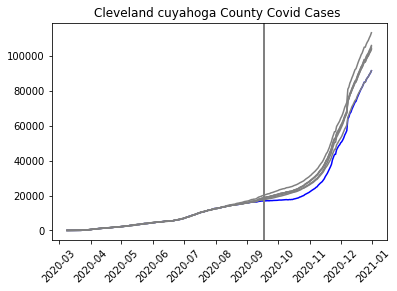

Dallas
Dallas
['dallas', 'tarrant']
['anderson', 'andrews', 'angelina', 'aransas', 'archer', 'atascosa', 'austin', 'bailey', 'bandera', 'bastrop', 'baylor', 'bee', 'bell', 'blanco', 'bosque', 'bowie', 'brazos', 'brewster', 'brooks', 'brown', 'burleson', 'burnet', 'caldwell', 'calhoun', 'callahan', 'cameron', 'camp', 'carson', 'cass', 'castro', 'chambers', 'cherokee', 'childress', 'clay', 'cochran', 'coke', 'coleman', 'collingsworth', 'colorado', 'comal', 'comanche', 'concho', 'cooke', 'coryell', 'crane', 'crockett', 'crosby', 'culberson', 'dallam', 'dawson', 'deaf smith', 'dewitt', 'dimmit', 'donley', 'duval', 'eastland', 'ellis', 'erath', 'falls', 'fannin', 'fayette', 'fisher', 'floyd', 'franklin', 'freestone', 'frio', 'gaines', 'garza', 'gillespie', 'goliad', 'gonzales', 'gray', 'grayson', 'gregg', 'grimes', 'guadalupe', 'hale', 'hall', 'hamilton', 'hansford', 'hardeman', 'hardin', 'harrison', 'hartley', 'haskell', 'hays', 'hemphill', 'henderson', 'hill', 'hockley', 'hood', 'hopkins'

38
Dallas
['dallas', 'tarrant']
['anderson', 'andrews', 'angelina', 'aransas', 'archer', 'atascosa', 'austin', 'bailey', 'bandera', 'bastrop', 'baylor', 'bee', 'bell', 'blanco', 'bosque', 'bowie', 'brazos', 'brewster', 'brooks', 'brown', 'burleson', 'burnet', 'caldwell', 'calhoun', 'callahan', 'cameron', 'camp', 'carson', 'cass', 'castro', 'chambers', 'cherokee', 'childress', 'clay', 'cochran', 'coke', 'coleman', 'collingsworth', 'colorado', 'comal', 'comanche', 'concho', 'cooke', 'coryell', 'crane', 'crockett', 'crosby', 'culberson', 'dallam', 'dawson', 'deaf smith', 'dewitt', 'dimmit', 'donley', 'duval', 'eastland', 'ellis', 'erath', 'falls', 'fannin', 'fayette', 'fisher', 'floyd', 'franklin', 'freestone', 'frio', 'gaines', 'garza', 'gillespie', 'goliad', 'gonzales', 'gray', 'grayson', 'gregg', 'grimes', 'guadalupe', 'hale', 'hall', 'hamilton', 'hansford', 'hardeman', 'hardin', 'harrison', 'hartley', 'haskell', 'hays', 'hemphill', 'henderson', 'hill', 'hockley', 'hood', 'hopkins', 'h

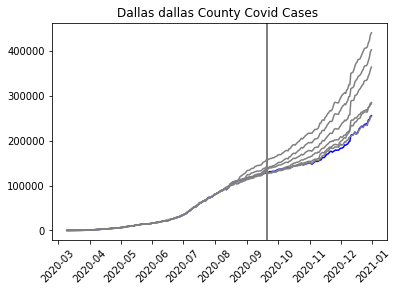

Denver
Denver
['denver', 'arapahoe']
['alamosa', 'archuleta', 'bent', 'chaffee', 'clear creek', 'conejos', 'crowley', 'delta', 'eagle', 'elbert', 'fremont', 'garfield', 'grand', 'gunnison', 'huerfano', 'kit carson', 'la plata', 'lake', 'las animas', 'lincoln', 'logan', 'mesa', 'moffat', 'montezuma', 'montrose', 'morgan', 'otero', 'park', 'phillips', 'pitkin', 'prowers', 'pueblo', 'rio blanco', 'rio grande', 'routt', 'saguache', 'san miguel', 'summit', 'teller', 'washington', 'yuma']
6
Denver
['denver', 'arapahoe']
['alamosa', 'archuleta', 'bent', 'chaffee', 'clear creek', 'conejos', 'crowley', 'delta', 'eagle', 'elbert', 'fremont', 'garfield', 'grand', 'gunnison', 'huerfano', 'kit carson', 'la plata', 'lake', 'las animas', 'lincoln', 'logan', 'mesa', 'moffat', 'montezuma', 'montrose', 'morgan', 'otero', 'park', 'phillips', 'pitkin', 'prowers', 'pueblo', 'rio blanco', 'rio grande', 'routt', 'saguache', 'san miguel', 'summit', 'teller', 'washington', 'yuma']
6
Denver
['denver', 'arapahoe

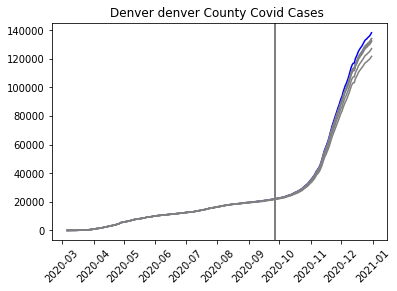

Detroit
Detroit
['wayne']
['alcona', 'alger', 'allegan', 'alpena', 'antrim', 'arenac', 'baraga', 'barry', 'bay', 'benzie', 'berrien', 'branch', 'calhoun', 'cass', 'charlevoix', 'cheboygan', 'chippewa', 'clare', 'clinton', 'crawford', 'delta', 'dickinson', 'eaton', 'emmet', 'genesee', 'gladwin', 'gogebic', 'grand traverse', 'gratiot', 'hillsdale', 'houghton', 'huron', 'ingham', 'ionia', 'iosco', 'iron', 'isabella', 'jackson', 'kalamazoo', 'kalkaska', 'kent', 'lake', 'lapeer', 'leelanau', 'lenawee', 'livingston', 'luce', 'mackinac', 'macomb', 'manistee', 'marquette', 'mason', 'mecosta', 'menominee', 'midland', 'missaukee', 'monroe', 'montcalm', 'montmorency', 'muskegon', 'newaygo', 'oakland', 'oceana', 'ogemaw', 'ontonagon', 'osceola', 'oscoda', 'otsego', 'ottawa', 'presque isle', 'roscommon', 'saginaw', 'sanilac', 'schoolcraft', 'shiawassee', 'st. clair', 'st. joseph', 'tuscola', 'van buren', 'washtenaw', 'wexford']
14
Detroit
['wayne']
['alcona', 'alger', 'allegan', 'alpena', 'antrim',

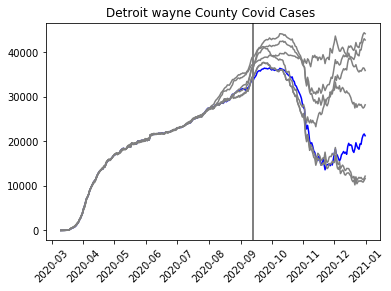

Green Bay
Green Bay
['brown']
['adams', 'ashland', 'barron', 'bayfield', 'buffalo', 'burnett', 'chippewa', 'clark', 'columbia', 'crawford', 'dodge', 'door', 'douglas', 'dunn', 'eau claire', 'florence', 'forest', 'grant', 'green', 'green lake', 'iowa', 'iron', 'jackson', 'jefferson', 'juneau', 'kewaunee', 'la crosse', 'lafayette', 'langlade', 'lincoln', 'marinette', 'marquette', 'menominee', 'monroe', 'oconto', 'oneida', 'pepin', 'pierce', 'polk', 'portage', 'price', 'richland', 'rock', 'rusk', 'sauk', 'sawyer', 'shawano', 'st. croix', 'taylor', 'trempealeau', 'vernon', 'vilas', 'walworth', 'washburn', 'waupaca', 'waushara', 'wood']
Uses all singular values initially
Our final Kept singular value
14
Green Bay
['brown']
['adams', 'ashland', 'barron', 'bayfield', 'buffalo', 'burnett', 'chippewa', 'clark', 'columbia', 'crawford', 'dodge', 'door', 'douglas', 'dunn', 'eau claire', 'florence', 'forest', 'grant', 'green', 'green lake', 'iowa', 'iron', 'jackson', 'jefferson', 'juneau', 'kewaune

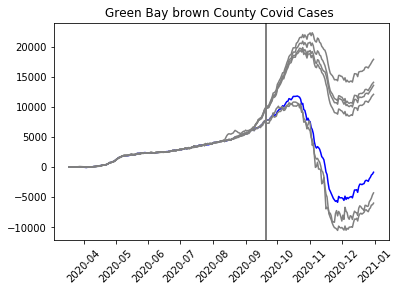

Houston
Houston
['harris']
['anderson', 'andrews', 'angelina', 'aransas', 'archer', 'atascosa', 'austin', 'bailey', 'bandera', 'bastrop', 'baylor', 'bee', 'bell', 'blanco', 'bosque', 'bowie', 'brazos', 'brewster', 'brooks', 'brown', 'burleson', 'burnet', 'caldwell', 'calhoun', 'callahan', 'cameron', 'camp', 'carson', 'cass', 'castro', 'chambers', 'cherokee', 'childress', 'clay', 'cochran', 'coke', 'coleman', 'collingsworth', 'colorado', 'comal', 'comanche', 'concho', 'cooke', 'coryell', 'crane', 'crockett', 'crosby', 'culberson', 'dallam', 'dawson', 'deaf smith', 'dewitt', 'dimmit', 'donley', 'duval', 'eastland', 'ellis', 'erath', 'falls', 'fannin', 'fayette', 'fisher', 'floyd', 'franklin', 'freestone', 'frio', 'gaines', 'garza', 'gillespie', 'goliad', 'gonzales', 'gray', 'grayson', 'gregg', 'grimes', 'guadalupe', 'hale', 'hall', 'hamilton', 'hansford', 'hardeman', 'hardin', 'harrison', 'hartley', 'haskell', 'hays', 'hemphill', 'henderson', 'hill', 'hockley', 'hood', 'hopkins', 'housto

14
Houston
['harris']
['anderson', 'andrews', 'angelina', 'aransas', 'archer', 'atascosa', 'austin', 'bailey', 'bandera', 'bastrop', 'baylor', 'bee', 'bell', 'blanco', 'bosque', 'bowie', 'brazos', 'brewster', 'brooks', 'brown', 'burleson', 'burnet', 'caldwell', 'calhoun', 'callahan', 'cameron', 'camp', 'carson', 'cass', 'castro', 'chambers', 'cherokee', 'childress', 'clay', 'cochran', 'coke', 'coleman', 'collingsworth', 'colorado', 'comal', 'comanche', 'concho', 'cooke', 'coryell', 'crane', 'crockett', 'crosby', 'culberson', 'dallam', 'dawson', 'deaf smith', 'dewitt', 'dimmit', 'donley', 'duval', 'eastland', 'ellis', 'erath', 'falls', 'fannin', 'fayette', 'fisher', 'floyd', 'franklin', 'freestone', 'frio', 'gaines', 'garza', 'gillespie', 'goliad', 'gonzales', 'gray', 'grayson', 'gregg', 'grimes', 'guadalupe', 'hale', 'hall', 'hamilton', 'hansford', 'hardeman', 'hardin', 'harrison', 'hartley', 'haskell', 'hays', 'hemphill', 'henderson', 'hill', 'hockley', 'hood', 'hopkins', 'houston', '

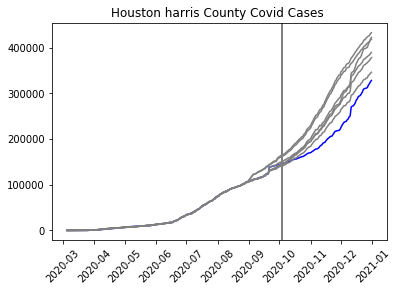

Indianapolis
Indianapolis
['marion']
['adams', 'bartholomew', 'benton', 'blackford', 'brown', 'carroll', 'cass', 'clark', 'clay', 'clinton', 'crawford', 'daviess', 'dearborn', 'decatur', 'dekalb', 'delaware', 'dubois', 'elkhart', 'fayette', 'floyd', 'fountain', 'franklin', 'fulton', 'gibson', 'grant', 'greene', 'harrison', 'henry', 'howard', 'huntington', 'jackson', 'jasper', 'jay', 'jefferson', 'jennings', 'knox', 'kosciusko', 'lagrange', 'lake', 'laporte', 'lawrence', 'marshall', 'martin', 'miami', 'monroe', 'montgomery', 'morgan', 'newton', 'noble', 'ohio', 'orange', 'owen', 'parke', 'perry', 'pike', 'porter', 'posey', 'pulaski', 'putnam', 'randolph', 'ripley', 'rush', 'scott', 'shelby', 'spencer', 'st. joseph', 'starke', 'steuben', 'sullivan', 'switzerland', 'tippecanoe', 'tipton', 'union', 'vermillion', 'vigo', 'wabash', 'warren', 'warrick', 'washington', 'wayne', 'wells', 'white', 'whitley']
9
Indianapolis
['marion']
['adams', 'bartholomew', 'benton', 'blackford', 'brown', 'carro

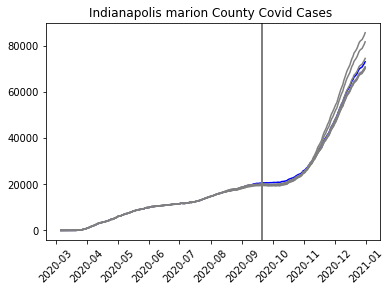

Jacksonville
Jacksonville
['duval']
['alachua', 'baker', 'bay', 'bradford', 'calhoun', 'charlotte', 'citrus', 'columbia', 'desoto', 'dixie', 'escambia', 'flagler', 'franklin', 'gadsden', 'gilchrist', 'glades', 'gulf', 'hamilton', 'hardee', 'hendry', 'highlands', 'holmes', 'indian river', 'jackson', 'jefferson', 'lafayette', 'lake', 'leon', 'levy', 'liberty', 'madison', 'marion', 'martin', 'monroe', 'okaloosa', 'okeechobee', 'osceola', 'putnam', 'santa rosa', 'st. johns', 'st. lucie', 'sumter', 'suwannee', 'taylor', 'union', 'wakulla', 'walton', 'washington']
9
Jacksonville
['duval']
['alachua', 'baker', 'bay', 'bradford', 'calhoun', 'charlotte', 'citrus', 'columbia', 'desoto', 'dixie', 'escambia', 'flagler', 'franklin', 'gadsden', 'gilchrist', 'glades', 'gulf', 'hamilton', 'hardee', 'hendry', 'highlands', 'holmes', 'indian river', 'jackson', 'jefferson', 'lafayette', 'lake', 'leon', 'levy', 'liberty', 'madison', 'marion', 'martin', 'monroe', 'okaloosa', 'okeechobee', 'osceola', 'putnam

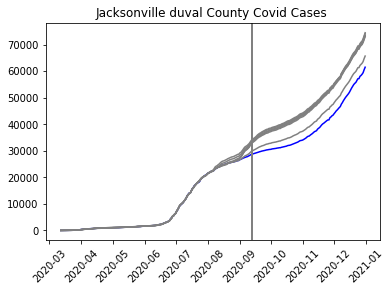

Kansas City
Kansas City
['johnson', 'jackson']
['allen', 'anderson', 'atchison', 'barber', 'barton', 'bourbon', 'brown', 'butler', 'chase', 'cherokee', 'cheyenne', 'clay', 'cloud', 'coffey', 'cowley', 'crawford', 'decatur', 'dickinson', 'doniphan', 'douglas', 'edwards', 'ellis', 'ellsworth', 'finney', 'ford', 'franklin', 'geary', 'gove', 'graham', 'grant', 'gray', 'greenwood', 'harper', 'harvey', 'haskell', 'jackson', 'jefferson', 'kearny', 'kingman', 'labette', 'leavenworth', 'lincoln', 'linn', 'logan', 'lyon', 'marion', 'marshall', 'mcpherson', 'meade', 'miami', 'mitchell', 'montgomery', 'morris', 'morton', 'nemaha', 'neosho', 'ness', 'norton', 'osage', 'ottawa', 'pawnee', 'phillips', 'pottawatomie', 'pratt', 'rawlins', 'reno', 'republic', 'rice', 'riley', 'rooks', 'rush', 'russell', 'saline', 'scott', 'seward', 'sheridan', 'sherman', 'smith', 'stafford', 'stevens', 'sumner', 'thomas', 'trego', 'wabaunsee', 'washington', 'wilson']
10
Kansas City
['johnson', 'jackson']
['allen', 'ande

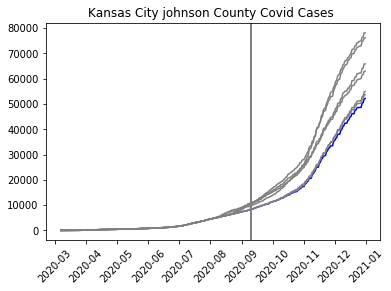

LA Chargers
LA Chargers
['los angeles']
['alameda', 'amador', 'butte', 'calaveras', 'colusa', 'contra costa', 'del norte', 'el dorado', 'fresno', 'glenn', 'humboldt', 'imperial', 'inyo', 'kern', 'kings', 'lake', 'lassen', 'madera', 'marin', 'mariposa', 'mendocino', 'merced', 'modoc', 'mono', 'monterey', 'napa', 'nevada', 'orange', 'placer', 'plumas', 'riverside', 'sacramento', 'san benito', 'san bernardino', 'san diego', 'san francisco', 'san joaquin', 'san luis obispo', 'santa barbara', 'santa cruz', 'shasta', 'siskiyou', 'solano', 'sonoma', 'stanislaus', 'sutter', 'tehama', 'trinity', 'tulare', 'tuolumne', 'ventura', 'yolo', 'yuba']
6
LA Chargers
['los angeles']
['alameda', 'amador', 'butte', 'calaveras', 'colusa', 'contra costa', 'del norte', 'el dorado', 'fresno', 'glenn', 'humboldt', 'imperial', 'inyo', 'kern', 'kings', 'lake', 'lassen', 'madera', 'marin', 'mariposa', 'mendocino', 'merced', 'modoc', 'mono', 'monterey', 'napa', 'nevada', 'orange', 'placer', 'plumas', 'riverside', '

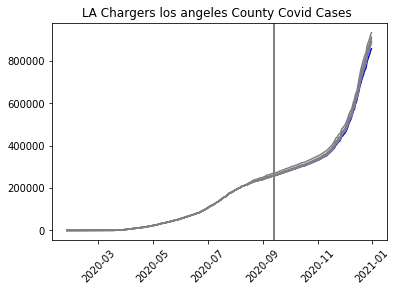

LA Rams
LA Rams
['los angeles']
['alameda', 'amador', 'butte', 'calaveras', 'colusa', 'contra costa', 'del norte', 'el dorado', 'fresno', 'glenn', 'humboldt', 'imperial', 'inyo', 'kern', 'kings', 'lake', 'lassen', 'madera', 'marin', 'mariposa', 'mendocino', 'merced', 'modoc', 'mono', 'monterey', 'napa', 'nevada', 'orange', 'placer', 'plumas', 'riverside', 'sacramento', 'san benito', 'san bernardino', 'san diego', 'san francisco', 'san joaquin', 'san luis obispo', 'santa barbara', 'santa cruz', 'shasta', 'siskiyou', 'solano', 'sonoma', 'stanislaus', 'sutter', 'tehama', 'trinity', 'tulare', 'tuolumne', 'ventura', 'yolo', 'yuba']
6
LA Rams
['los angeles']
['alameda', 'amador', 'butte', 'calaveras', 'colusa', 'contra costa', 'del norte', 'el dorado', 'fresno', 'glenn', 'humboldt', 'imperial', 'inyo', 'kern', 'kings', 'lake', 'lassen', 'madera', 'marin', 'mariposa', 'mendocino', 'merced', 'modoc', 'mono', 'monterey', 'napa', 'nevada', 'orange', 'placer', 'plumas', 'riverside', 'sacramento',

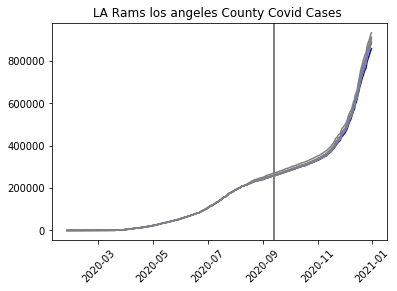

Las Vegas
Las Vegas
['clark']
['carson city', 'churchill', 'douglas', 'elko', 'humboldt', 'lander', 'lincoln', 'lyon', 'nye', 'pershing', 'washoe', 'white pine']
Uses all singular values initially
Our final Kept singular value
4
Las Vegas
['clark']
['carson city', 'churchill', 'douglas', 'elko', 'humboldt', 'lander', 'lincoln', 'lyon', 'nye', 'pershing', 'washoe', 'white pine']
Uses all singular values initially
Our final Kept singular value
5
Las Vegas
['clark']
['carson city', 'churchill', 'douglas', 'elko', 'humboldt', 'lander', 'lincoln', 'lyon', 'nye', 'pershing', 'washoe', 'white pine']
Uses all singular values initially
Our final Kept singular value
5
Las Vegas
['clark']
['carson city', 'churchill', 'douglas', 'elko', 'humboldt', 'lander', 'lincoln', 'lyon', 'nye', 'pershing', 'washoe', 'white pine']
Uses all singular values initially
Our final Kept singular value
3
Las Vegas
['clark']
['carson city', 'churchill', 'douglas', 'elko', 'humboldt', 'lander', 'lincoln', 'lyon', 'nye'

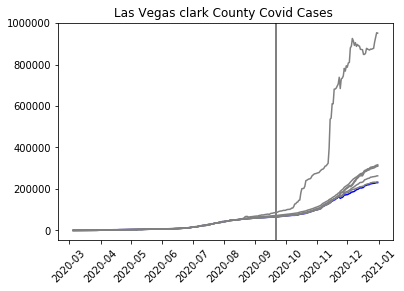

Miami
Miami
['broward', 'miami-dade', 'palm beach']
['alachua', 'baker', 'bay', 'bradford', 'calhoun', 'charlotte', 'citrus', 'columbia', 'desoto', 'dixie', 'escambia', 'flagler', 'franklin', 'gadsden', 'gilchrist', 'glades', 'gulf', 'hamilton', 'hardee', 'hendry', 'highlands', 'holmes', 'indian river', 'jackson', 'jefferson', 'lafayette', 'lake', 'leon', 'levy', 'liberty', 'madison', 'marion', 'martin', 'monroe', 'okaloosa', 'okeechobee', 'osceola', 'putnam', 'santa rosa', 'st. johns', 'st. lucie', 'sumter', 'suwannee', 'taylor', 'union', 'wakulla', 'walton', 'washington']
7
Miami
['broward', 'miami-dade', 'palm beach']
['alachua', 'baker', 'bay', 'bradford', 'calhoun', 'charlotte', 'citrus', 'columbia', 'desoto', 'dixie', 'escambia', 'flagler', 'franklin', 'gadsden', 'gilchrist', 'glades', 'gulf', 'hamilton', 'hardee', 'hendry', 'highlands', 'holmes', 'indian river', 'jackson', 'jefferson', 'lafayette', 'lake', 'leon', 'levy', 'liberty', 'madison', 'marion', 'martin', 'monroe', 'okal

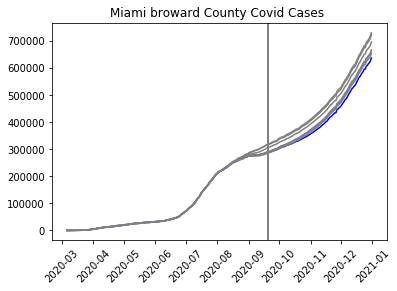

Minnesota
Minnesota
['ramsey']
['aitkin', 'anoka', 'becker', 'beltrami', 'benton', 'big stone', 'blue earth', 'brown', 'carlton', 'carver', 'cass', 'chippewa', 'chisago', 'clay', 'clearwater', 'cottonwood', 'crow wing', 'dakota', 'dodge', 'douglas', 'faribault', 'fillmore', 'freeborn', 'goodhue', 'grant', 'houston', 'hubbard', 'isanti', 'itasca', 'jackson', 'kanabec', 'kandiyohi', 'kittson', 'koochiching', 'lac qui parle', 'lake', 'le sueur', 'lincoln', 'lyon', 'mahnomen', 'marshall', 'martin', 'mcleod', 'meeker', 'mille lacs', 'morrison', 'mower', 'murray', 'nicollet', 'nobles', 'norman', 'olmsted', 'otter tail', 'pennington', 'pine', 'pipestone', 'polk', 'pope', 'red lake', 'redwood', 'renville', 'rice', 'rock', 'roseau', 'scott', 'sherburne', 'sibley', 'st. louis', 'stearns', 'steele', 'stevens', 'swift', 'todd', 'traverse', 'wabasha', 'wadena', 'waseca', 'washington', 'watonwan', 'wilkin', 'winona', 'wright', 'yellow medicine']
6
Minnesota
['ramsey']
['aitkin', 'anoka', 'becker', '

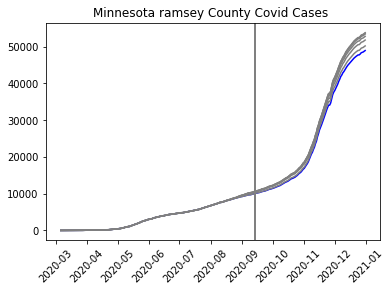

NY Giants
NY Giants
['bergen']
['cape may', 'cumberland', 'essex', 'hudson', 'hunterdon', 'mercer', 'middlesex', 'monmouth', 'morris', 'passaic', 'salem', 'somerset', 'sussex', 'union', 'warren']
3
NY Giants
['bergen']
['cape may', 'cumberland', 'essex', 'hudson', 'hunterdon', 'mercer', 'middlesex', 'monmouth', 'morris', 'passaic', 'salem', 'somerset', 'sussex', 'union', 'warren']
3
NY Giants
['bergen']
['cape may', 'cumberland', 'essex', 'hudson', 'hunterdon', 'mercer', 'middlesex', 'monmouth', 'morris', 'passaic', 'salem', 'somerset', 'sussex', 'union', 'warren']
3
NY Giants
['bergen']
['cape may', 'cumberland', 'essex', 'hudson', 'hunterdon', 'mercer', 'middlesex', 'monmouth', 'morris', 'passaic', 'salem', 'somerset', 'sussex', 'union', 'warren']
3
NY Giants
['bergen']
['cape may', 'cumberland', 'essex', 'hudson', 'hunterdon', 'mercer', 'middlesex', 'monmouth', 'morris', 'passaic', 'salem', 'somerset', 'sussex', 'union', 'warren']
3
NY Giants
['bergen']
['cape may', 'cumberland', 'e

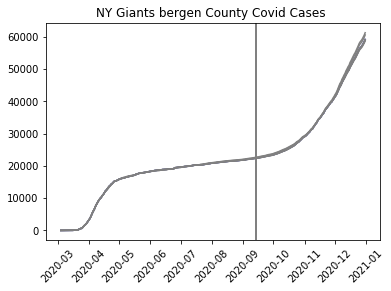

NY Jets
NY Jets
['bergen']
['cape may', 'cumberland', 'essex', 'hudson', 'hunterdon', 'mercer', 'middlesex', 'monmouth', 'morris', 'passaic', 'salem', 'somerset', 'sussex', 'union', 'warren']
3
NY Jets
['bergen']
['cape may', 'cumberland', 'essex', 'hudson', 'hunterdon', 'mercer', 'middlesex', 'monmouth', 'morris', 'passaic', 'salem', 'somerset', 'sussex', 'union', 'warren']
3
NY Jets
['bergen']
['cape may', 'cumberland', 'essex', 'hudson', 'hunterdon', 'mercer', 'middlesex', 'monmouth', 'morris', 'passaic', 'salem', 'somerset', 'sussex', 'union', 'warren']
3
NY Jets
['bergen']
['cape may', 'cumberland', 'essex', 'hudson', 'hunterdon', 'mercer', 'middlesex', 'monmouth', 'morris', 'passaic', 'salem', 'somerset', 'sussex', 'union', 'warren']
3
NY Jets
['bergen']
['cape may', 'cumberland', 'essex', 'hudson', 'hunterdon', 'mercer', 'middlesex', 'monmouth', 'morris', 'passaic', 'salem', 'somerset', 'sussex', 'union', 'warren']
3
NY Jets
['bergen']
['cape may', 'cumberland', 'essex', 'hudson

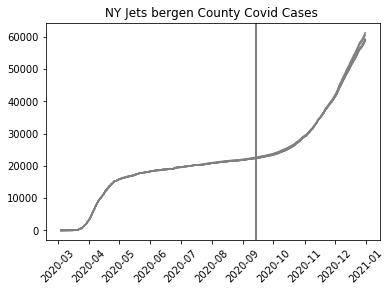

New England
New England
['norfolk']
['barnstable', 'berkshire', 'bristol', 'dukes', 'essex', 'franklin', 'hampden', 'hampshire', 'middlesex', 'nantucket', 'plymouth', 'suffolk', 'worcester']
7
New England
['norfolk']
['barnstable', 'berkshire', 'bristol', 'dukes', 'essex', 'franklin', 'hampden', 'hampshire', 'middlesex', 'nantucket', 'plymouth', 'suffolk', 'worcester']
Uses all singular values initially
Our final Kept singular value
4
New England
['norfolk']
['barnstable', 'berkshire', 'bristol', 'dukes', 'essex', 'franklin', 'hampden', 'hampshire', 'middlesex', 'nantucket', 'plymouth', 'suffolk', 'worcester']
3
New England
['norfolk']
['barnstable', 'berkshire', 'bristol', 'dukes', 'essex', 'franklin', 'hampden', 'hampshire', 'middlesex', 'nantucket', 'plymouth', 'suffolk', 'worcester']
3
New England
['norfolk']
['barnstable', 'berkshire', 'bristol', 'dukes', 'essex', 'franklin', 'hampden', 'hampshire', 'middlesex', 'nantucket', 'plymouth', 'suffolk', 'worcester']
3
New England
['norf

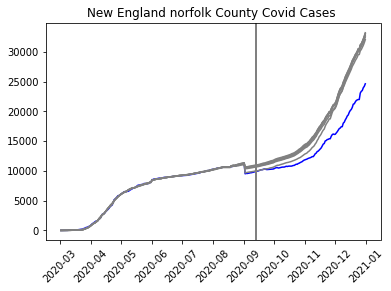

New Orleans
New Orleans
['orleans']
['acadia', 'allen', 'ascension', 'assumption', 'avoyelles', 'beauregard', 'bienville', 'bossier', 'caddo', 'calcasieu', 'caldwell', 'cameron', 'catahoula', 'claiborne', 'concordia', 'de soto', 'east baton rouge', 'east carroll', 'east feliciana', 'evangeline', 'franklin', 'grant', 'iberia', 'iberville', 'jackson', 'jefferson', 'jefferson davis', 'lafayette', 'lafourche', 'lasalle', 'lincoln', 'livingston', 'madison', 'morehouse', 'natchitoches', 'ouachita', 'plaquemines', 'pointe coupee', 'rapides', 'red river', 'richland', 'sabine', 'st. bernard', 'st. charles', 'st. helena', 'st. james', 'st. john the baptist', 'st. landry', 'st. martin', 'st. mary', 'st. tammany', 'tangipahoa', 'tensas', 'terrebonne', 'union', 'vermilion', 'vernon', 'washington', 'webster', 'west baton rouge', 'west carroll', 'west feliciana', 'winn']
Uses all singular values initially
Our final Kept singular value
10
New Orleans
['orleans']
['acadia', 'allen', 'ascension', 'assum

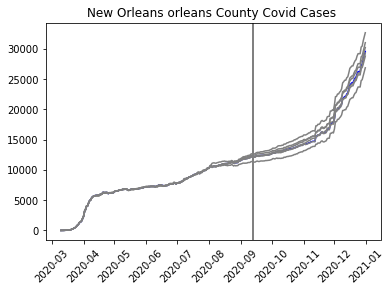

Philadelphia
Philadelphia
['philadelphia']
['adams', 'armstrong', 'bedford', 'blair', 'bradford', 'cambria', 'carbon', 'centre', 'clarion', 'clearfield', 'clinton', 'columbia', 'crawford', 'cumberland', 'dauphin', 'elk', 'erie', 'forest', 'franklin', 'fulton', 'greene', 'huntingdon', 'indiana', 'jefferson', 'juniata', 'lackawanna', 'lawrence', 'lebanon', 'lehigh', 'luzerne', 'lycoming', 'mckean', 'mercer', 'mifflin', 'monroe', 'montour', 'northampton', 'northumberland', 'perry', 'pike', 'potter', 'schuylkill', 'snyder', 'somerset', 'susquehanna', 'tioga', 'union', 'venango', 'warren', 'wayne', 'wyoming']
8
Philadelphia
['philadelphia']
['adams', 'armstrong', 'bedford', 'blair', 'bradford', 'cambria', 'carbon', 'centre', 'clarion', 'clearfield', 'clinton', 'columbia', 'crawford', 'cumberland', 'dauphin', 'elk', 'erie', 'forest', 'franklin', 'fulton', 'greene', 'huntingdon', 'indiana', 'jefferson', 'juniata', 'lackawanna', 'lawrence', 'lebanon', 'lehigh', 'luzerne', 'lycoming', 'mckean',

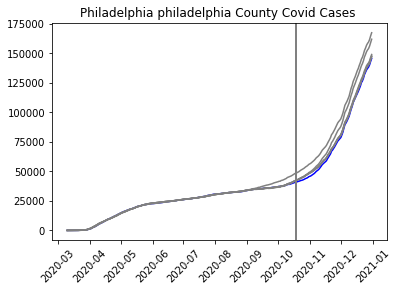

Pittsburgh
Pittsburgh
['allegheny']
['adams', 'armstrong', 'bedford', 'blair', 'bradford', 'cambria', 'carbon', 'centre', 'clarion', 'clearfield', 'clinton', 'columbia', 'crawford', 'cumberland', 'dauphin', 'elk', 'erie', 'forest', 'franklin', 'fulton', 'greene', 'huntingdon', 'indiana', 'jefferson', 'juniata', 'lackawanna', 'lawrence', 'lebanon', 'lehigh', 'luzerne', 'lycoming', 'mckean', 'mercer', 'mifflin', 'monroe', 'montour', 'northampton', 'northumberland', 'perry', 'pike', 'potter', 'schuylkill', 'snyder', 'somerset', 'susquehanna', 'tioga', 'union', 'venango', 'warren', 'wayne', 'wyoming']
22
Pittsburgh
['allegheny']
['adams', 'armstrong', 'bedford', 'blair', 'bradford', 'cambria', 'carbon', 'centre', 'clarion', 'clearfield', 'clinton', 'columbia', 'crawford', 'cumberland', 'dauphin', 'elk', 'erie', 'forest', 'franklin', 'fulton', 'greene', 'huntingdon', 'indiana', 'jefferson', 'juniata', 'lackawanna', 'lawrence', 'lebanon', 'lehigh', 'luzerne', 'lycoming', 'mckean', 'mercer', 

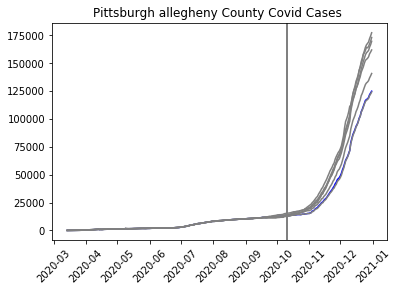

San Francisco
San Francisco
['santa clara']
['alameda', 'amador', 'butte', 'calaveras', 'colusa', 'contra costa', 'del norte', 'el dorado', 'fresno', 'glenn', 'humboldt', 'imperial', 'inyo', 'kern', 'kings', 'lake', 'lassen', 'madera', 'marin', 'mariposa', 'mendocino', 'merced', 'modoc', 'mono', 'monterey', 'napa', 'nevada', 'orange', 'placer', 'plumas', 'riverside', 'sacramento', 'san benito', 'san bernardino', 'san diego', 'san francisco', 'san joaquin', 'san luis obispo', 'santa barbara', 'santa cruz', 'shasta', 'siskiyou', 'solano', 'sonoma', 'stanislaus', 'sutter', 'tehama', 'trinity', 'tulare', 'tuolumne', 'ventura', 'yolo', 'yuba']
Uses all singular values initially
Our final Kept singular value
12
San Francisco
['santa clara']
['alameda', 'amador', 'butte', 'calaveras', 'colusa', 'contra costa', 'del norte', 'el dorado', 'fresno', 'glenn', 'humboldt', 'imperial', 'inyo', 'kern', 'kings', 'lake', 'lassen', 'madera', 'marin', 'mariposa', 'mendocino', 'merced', 'modoc', 'mono', 'm

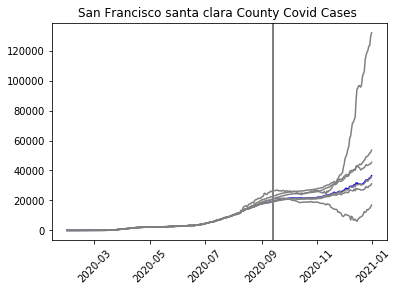

Seattle
Seattle
['king']
['adams', 'asotin', 'benton', 'chelan', 'clallam', 'clark', 'cowlitz', 'douglas', 'franklin', 'grant', 'grays harbor', 'island', 'jefferson', 'kitsap', 'kittitas', 'klickitat', 'lewis', 'lincoln', 'mason', 'okanogan', 'pacific', 'pend oreille', 'pierce', 'skagit', 'snohomish', 'spokane', 'stevens', 'thurston', 'walla walla', 'whatcom', 'whitman', 'yakima']
Uses all singular values initially
Our final Kept singular value
5
Seattle
['king']
['adams', 'asotin', 'benton', 'chelan', 'clallam', 'clark', 'cowlitz', 'douglas', 'franklin', 'grant', 'grays harbor', 'island', 'jefferson', 'kitsap', 'kittitas', 'klickitat', 'lewis', 'lincoln', 'mason', 'okanogan', 'pacific', 'pend oreille', 'pierce', 'skagit', 'snohomish', 'spokane', 'stevens', 'thurston', 'walla walla', 'whatcom', 'whitman', 'yakima']
Uses all singular values initially
Our final Kept singular value
5
Seattle
['king']
['adams', 'asotin', 'benton', 'chelan', 'clallam', 'clark', 'cowlitz', 'douglas', 'frankl

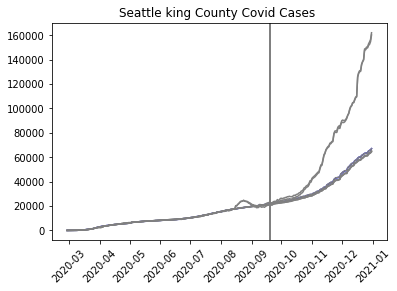

Tampa Bay
Tampa Bay
['hillsborough', 'pinellas']
['alachua', 'baker', 'bay', 'bradford', 'calhoun', 'charlotte', 'citrus', 'columbia', 'desoto', 'dixie', 'escambia', 'flagler', 'franklin', 'gadsden', 'gilchrist', 'glades', 'gulf', 'hamilton', 'hardee', 'hendry', 'highlands', 'holmes', 'indian river', 'jackson', 'jefferson', 'lafayette', 'lake', 'leon', 'levy', 'liberty', 'madison', 'marion', 'martin', 'monroe', 'okaloosa', 'okeechobee', 'osceola', 'putnam', 'santa rosa', 'st. johns', 'st. lucie', 'sumter', 'suwannee', 'taylor', 'union', 'wakulla', 'walton', 'washington']
8
Tampa Bay
['hillsborough', 'pinellas']
['alachua', 'baker', 'bay', 'bradford', 'calhoun', 'charlotte', 'citrus', 'columbia', 'desoto', 'dixie', 'escambia', 'flagler', 'franklin', 'gadsden', 'gilchrist', 'glades', 'gulf', 'hamilton', 'hardee', 'hendry', 'highlands', 'holmes', 'indian river', 'jackson', 'jefferson', 'lafayette', 'lake', 'leon', 'levy', 'liberty', 'madison', 'marion', 'martin', 'monroe', 'okaloosa', 'ok

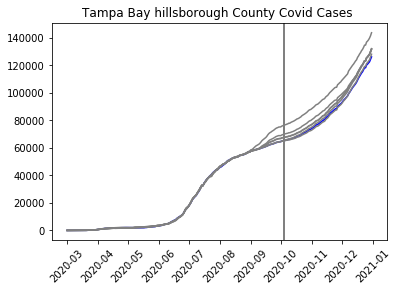

Tennessee
Tennessee
['davidson', 'williamson']
['anderson', 'bedford', 'benton', 'bledsoe', 'blount', 'bradley', 'campbell', 'cannon', 'carroll', 'carter', 'chester', 'claiborne', 'clay', 'cocke', 'coffee', 'crockett', 'cumberland', 'decatur', 'dekalb', 'dickson', 'dyer', 'fayette', 'fentress', 'franklin', 'gibson', 'giles', 'grainger', 'greene', 'grundy', 'hamblen', 'hamilton', 'hancock', 'hardeman', 'hardin', 'hawkins', 'haywood', 'henderson', 'henry', 'hickman', 'houston', 'humphreys', 'jackson', 'jefferson', 'johnson', 'lake', 'lauderdale', 'lawrence', 'lewis', 'lincoln', 'loudon', 'macon', 'madison', 'marion', 'marshall', 'mcminn', 'mcnairy', 'meigs', 'monroe', 'moore', 'morgan', 'obion', 'overton', 'perry', 'pickett', 'polk', 'putnam', 'rhea', 'roane', 'scott', 'sequatchie', 'sevier', 'smith', 'stewart', 'sullivan', 'tipton', 'trousdale', 'unicoi', 'union', 'van buren', 'warren', 'washington', 'wayne', 'weakley', 'white']
14
Tennessee
['davidson', 'williamson']
['anderson', 'bedf

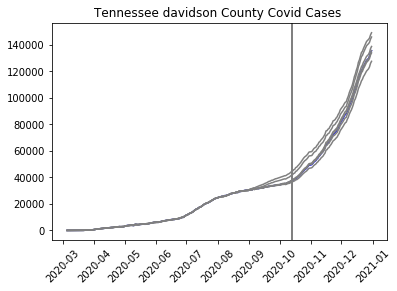

In [623]:
#Compute graphs for all combinations 

dropped_stadium_df = stadium_county_df[['Team', 'First date home stadium open to fans','County(s)', 'State']]
dropped_stadium_df = dropped_stadium_df.fillna("")
grouped_df = dropped_stadium_df.groupby('Team').agg(list)
grouped_df.reset_index(inplace=True)

#We want to manually fill in Dates for stadiums not open to fans, easier this way. 
grouped_df.loc[grouped_df['Team'] == 'Chicago', 'First date home stadium open to fans'] = [['9/20/2020']]
grouped_df.loc[grouped_df['Team'] == 'Detroit', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Las Vegas', 'First date home stadium open to fans'] = [['9/21/2020']]
grouped_df.loc[grouped_df['Team'] == 'LA Chargers', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'LA Rams', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Minnesota', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'New England', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'New Orleans', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'NY Giants', 'First date home stadium open to fans'] = [['9/14/2020']]
grouped_df.loc[grouped_df['Team'] == 'NY Jets', 'First date home stadium open to fans'] = [['9/14/2020']]
grouped_df.loc[grouped_df['Team'] == 'San Francisco', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Seattle', 'First date home stadium open to fans'] = [['9/20/2020']]
grouped_df.loc[grouped_df['Team'] == 'Tennessee', 'First date home stadium open to fans'] = [['10/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Washington', 'First date home stadium open to fans'] = [['9/13/2020']]
grouped_df.loc[grouped_df['Team'] == 'Pittsburgh', 'First date home stadium open to fans'] = [['10/11/2020']]
grouped_df.loc[grouped_df['Team'] == 'Kansas City', 'First date home stadium open to fans'] = [['9/10/2020']] #Error in data set

#dropped_stadium_df = dropped_stadium_df.drop_duplicates(subset='Team') #Only need 1 for each team
zipped_input = zip(grouped_df['Team'], grouped_df['County(s)'], grouped_df['State'], grouped_df['First date home stadium open to fans'])

# for i, (team, county, state, date) in enumerate(zipped_input):
#     if (team != 'Washington'):
#         create_synthetic_graph(team, county, state, date)
    
for i, (team, county, state, date) in enumerate(zipped_input):
    if team != "Washington":
        create_synthetic_lines(team, county, state, date)
        plt.show()


In [ ]:
#create_synthetic_lines("Kansas City",["Johnson", "Jackson"], ["KS", "MO"], ["09/10/2020"])

In [ ]:
#Create graphs for results after Game day. 

#Total_prediction_data should have

print(np.array(Total_prediction_data_no_fans).shape)


assert np.array(Total_prediction_data_no_fans).shape == (14, 21) #NUmber of teams, number of days past intervention
assert np.array(Total_prediction_data_fans).shape == (17, 21)

IQR_list = []

Time_series_no_fans = np.array(Total_prediction_data_no_fans).T #Transpose of time series data
Time_series_fans = np.array(Total_prediction_data_fans).T

# q1, q3 = np.percentile(Time_series, [25, 75], axis=1)
# iqr = q3 - q1

# print(q1)
# print(q3)

#plt.fill_betweenx(np.arange(len(iqr)), q1, q3, color='b', alpha=0.2)
fig, ax = plt.subplots()

plt.boxplot(Time_series_no_fans.T, vert=True, showfliers = False)
ax.set_ylim(bottom=-0.3,top = 0.3)
plt.xlabel("Days after Intervention")
plt.ylabel("Relative Difference Delta")
plt.title("Days after Intervention Delta for Stadium with No Fans")
ax.axhline(0, color='grey', linestyle='--')

# Show the plot
plt.show()

fig,ax = plt.subplots()

plt.boxplot(Time_series_fans.T, vert=True, showfliers = False)
ax.set_ylim(bottom=-0.3,top=0.3)

plt.xlabel("Days after Intervention")
plt.ylabel("Relative Difference Delta")
plt.title("Days after Intervention Delta for Stadium with Fans")
ax.axhline(0, color='grey', linestyle='--')
plt.show()
    

In [ ]:
#MCMC Bayesian factor Synthetic Control

#Donors and Target. Key idea in Synthetic control is to learn some model to predict the values in target based on donors.

#Original method proves that you can caputre causal effects only if it's linear. 

#What we're trying to show is that a general model applies. 

#Draft that is a mess right now. 

#Stat 348. 

#Knowing Z gives me all the information about Y. 

#Probabilistic version of PCA

#Find a factor model, poisson factor. MCMC bayesian inference. 

#familiarize with PYRO, probabilistic programming framework. 

#Want to compute posterior given what you observe. Usually, the denominator you don't know how to compute. 

#So you have to approximate that integral. MCMC samples from the posterior. 

#Bayesian factor model generative story for the data, then gain back sample from the posterior. 

#Search through space of models efficiently, specify generative model and then get back posterior sample. 

#Alternative to PYRO is implementation, find alternative to probabilistic PCA and bayesian poisson factorization. 

#Probabilistic PCA bayesian, and poisson factorization samples of the posterior, apply it to dataset. 

#And then we will see how to check the models. 

#You are going to implement a function that can generate samples of data. Function represents hypothesis on how the dataset 
#Probabilistic generative for your data. Now give me a datset and I will sample from the posterior distribution from that data. 